# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Nesse modelo vamos passar a considerar os textos das íntegras.

A primeira passagem, serão criadas colunas com as palavras-chaves informadas pela área negocial que vão indicar a ausência ou presença do termo no texto da íntegra da peça de promoção do arquivamento.

Na segunda passagem, vamos passar a considerar unicamente o texto da íntegra.

**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados.

Vamos ler os textos das íntegras, limpá-los e associar ao dataframe com os dados de homologação.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"

In [4]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andrethiago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/andrethiago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# carga dos textos

from os import listdir
from os.path import isfile, join
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('portuguese')
stop_words.extend(['n', 'nº', 'n°', 'n.º', ',', '.', '!', '?', ';', ':', '...', 'º', '–', '/', '(', ')'])

def get_text(file):
    with open(file, encoding='utf-8', errors='replace') as f:
        data=' '.join(line.strip() for line in f)
        f.close()
    
    return data.strip()

def get_text_non_stop_words(text):
    filtered_text = ''
    for w in word_tokenize(text, language='portuguese'):
        if w not in stop_words:
            filtered_text += w
            filtered_text += ' '            
    return filtered_text.strip()   
    

folder_integras = f'{PATH}/integras-textos'

texts = {}
for file in listdir(folder_integras):
    if isfile(join(folder_integras, file)):
        texts[file.split('.')[0]] = get_text(join(folder_integras,file))
    else:
        print('is not file', file)

    
#texts['71078312']

In [6]:
# montando um DataFrame
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')
df_work = df_original.copy()
cols = ['id', 'homologado']
df_work.drop(inplace=True, columns=[col for col in df_work.columns if col not in cols])
df_work['peca_promocao'] = None
df_work.sample(5)

,homologado,id,peca_promocao
552,1,82304209,None
5783,1,68200684,None
3520,1,73833781,None
2623,1,64336691,None
1483,1,83888377,None


In [7]:
# Associando o texto...
for key, text in zip(texts.keys(), texts.values()):
    if key != '' and text != '':
        df_work.loc[df_work.id == int(key), 'peca_promocao'] = text
        
df_work.sample(5)

,homologado,id,peca_promocao
5359,1,69009689,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...
5106,1,68601118,Scanned Document
5891,1,40246922,None
4363,1,35720472,93 3522-8373/3522-8372 - www.prpa.mpf.mp.br – ...
399,1,86540199,PRM-JZN-CE-00004540/2018 MINISTÉRIO PÚBLICO F...


In [8]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

6122 94


In [9]:
# removendo os sem textos de peça de promoção (problema nos dados)
print(len(df_work[df_work['peca_promocao'].isnull()]))
df_work.dropna(subset=['peca_promocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)
print(len(df_work[df_work['peca_promocao'].isnull()]))

1401
0


In [10]:
print(len(df_work[df_work['homologado'] == 1]), len(df_work[df_work['homologado'] == 0]))

4742 73


In [11]:
#Carga das palavras chaves
palavras_chaves = pd.read_csv(f'{PATH}/1A.CAM.palavras-chaves.txt')
palavras_chaves

,palavras-chaves,expressao-regular
0,AUSÊNCIA DE IRREGULARIDADES,\bausência[s]?\b(\s)+\bde\b(\s)+\birregularida...
1,IRREGULARIDADE SANADA,\birregularidade[s]?\b(\s)+\bsanada[s]?\b
2,NÃO COMPROVAÇÃO,\bnão\b(\s)+\bcomprovação\b
3,INEXISTÊNCIA,\binexistência[s]?\b
4,SOLUCIONADA,\bsolucionada[s]?\b
5,EXAURIMENTO,\bexaurimento\b
6,EXAURIDA,\bexaurida[s]?\b
7,PERDA DE OBJETO,\bperda\b(\s)+\bde\b(\s)+\bobjeto\b
8,IRREGULARIDADE NÃO COMPROVADA,\birregularidade[s]?\b(\s)+\bnão\b(\s)+\bcompr...
9,INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE,\binexistência\b(\s)+\bde\b(\s)+\bindício[s]?\...


## Busca de palavras-chaves nos textos das peças de promoção

Dada a lista de palavras-chaves anteriormente listada, vamos procurá-la nos textos das íntegras.

Vamos criar uma coluna para cada uma das palavras-chaves e marcar com ausência ou presença da mesma no texto correspondente.

Vamos utilzar expressões regulares.

In [12]:
pcs = palavras_chaves['palavras-chaves']

# vou ignorar as colunas com o caractere '+' // PRECISAMOS TRATAR ISSO AINDA
for pc in pcs:
    if pc.rfind('+') == -1:
        df_work[pc.strip()] = 0

df_work.sample(5)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
4735,1,62176703,Manual Ministério Público Federal Procurador...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1049,1,49275720,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3916,1,67161848,EXCELENTÍSSIMO(A) SENHOR(A) COORDENADOR(A) DA ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,1,80614877,MINISTÉRIO PÚBLICO FEDERAL Procuradoria da Rep...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2239,1,73182844,Ofício nº 001/01-GAB/PRE/CE PR-CE-00022611/2...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import re

for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        regex = re.compile(palavras_chaves['expressao-regular'][i], re.IGNORECASE)
        column = palavras_chaves['palavras-chaves'][i]
        for key in range(len(df_work)):
            if re.search(regex, df_work['peca_promocao'][key]):
                df_work.loc[key, column] = 1
            
df_work.sample(10)

,homologado,id,peca_promocao,AUSÊNCIA DE IRREGULARIDADES,IRREGULARIDADE SANADA,NÃO COMPROVAÇÃO,INEXISTÊNCIA,SOLUCIONADA,EXAURIMENTO,EXAURIDA,...,INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES,RECOMENDAÇÃO EXPEDIDA E ACATADA,JUSTIFICATIVAS SATISFATÓRIAS,CORREÇÃO DAS FALHAS,AÇÃO AJUIZADA,QUESTÃO JUDICIALIZADA,DIREITO INDIVIDUAL,EXCESSO DE PESO,MAMOGRAFIA,SISCAN
4265,1,66517753,MPF-RS Inquérito Civil nº 1.29.002.000305/201...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4623,1,63366065,MINISTÉRIO PÚBLICO FEDERAL Inquérito Civil Pú...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4241,1,69444850,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA RE...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
937,1,77888622,Ofício MPF/PRPE/AT nº 171 /2003 MINISTÉRIO P...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2517,1,75309327,NOTÍCIA DE FATO: 1.33.011.000193/2016-49 PRO...,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3437,1,70321661,ARQUIVAMENTO PP 1.22.024.000040/2016-36 Repre...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,0,70791835,000116 2016-10 arquivamento em 17.05.18 MINI...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,1,78518636,MINISTÉRIO PÚBLICO FEDERAL PROCURADORIA DA REP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3063,1,68856988,MINISTÉRIO PÚBLICO FEDERAL Procuradoria da Rep...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429,1,82526199,Ref. Notícia de Fato n. 1.28.000.002136/2017-7...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlacionando as palavras-chaves com a homologação/não homologação

A ideia aqui é mostrar o percentual de presença/ausência de palavras chaves e suas relações com a variável dependente.

In [14]:
df_homologado = df_work[df_work['homologado'] == 1]
df_nao_homologado = df_work[df_work['homologado'] == 0]
len(df_homologado), len(df_nao_homologado)

(4742, 73)

In [15]:
# verificando a porcentagem nos homologados
p_homologados = {}
for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        column = str(palavras_chaves['palavras-chaves'][i])
        len_column = len(df_homologado[df_homologado[column] == 1])
        p_homologados[column] = len_column


print(sorted(p_homologados.items(), key=lambda kv: kv[1]))

[('INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES', 0), ('RECOMENDAÇÃO EXPEDIDA E ACATADA', 0), ('JUSTIFICATIVAS SATISFATÓRIAS', 1), ('IRREGULARIDADE NÃO CONFIRMADA', 2), ('IRREGULARIDADE NÃO COMPROVADA', 4), ('INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE', 4), ('RECOMENDAÇÃO ATENDIDA', 7), ('MAMOGRAFIA', 7), ('RECOMENDAÇÃO ACATADA', 9), ('CORREÇÃO DAS FALHAS', 10), ('AÇÃO AJUIZADA', 12), ('QUESTÃO JUDICIALIZADA', 15), ('SISCAN', 16), ('NÃO COMPROVAÇÃO', 24), ('IRREGULARIDADE SANADA', 34), ('PERDA DE OBJETO', 38), ('EXAURIMENTO', 59), ('EXAURIDA', 65), ('EXCESSO DE PESO', 89), ('SOLUCIONADA', 111), ('CUMPRIDAS', 228), ('DIREITO INDIVIDUAL', 242), ('AUSÊNCIA DE IRREGULARIDADES', 303), ('INEXISTÊNCIA', 782), ('ADOTADAS', 1181)]


In [16]:
# verificando a quantidade nos não homologados
p_nao_homologados = {}
for i in range(len(palavras_chaves)):
    if palavras_chaves['palavras-chaves'][i].rfind('+') == -1:
        column = str(palavras_chaves['palavras-chaves'][i])
        len_column = len(df_nao_homologado[df_nao_homologado[column] == 1])
        p_nao_homologados[column] = len_column


print(sorted(p_nao_homologados.items(), key=lambda kv: kv[1]))

[('IRREGULARIDADE SANADA', 0), ('EXAURIMENTO', 0), ('IRREGULARIDADE NÃO COMPROVADA', 0), ('INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE', 0), ('IRREGULARIDADE NÃO CONFIRMADA', 0), ('RECOMENDAÇÃO ATENDIDA', 0), ('RECOMENDAÇÃO ACATADA', 0), ('INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES', 0), ('RECOMENDAÇÃO EXPEDIDA E ACATADA', 0), ('JUSTIFICATIVAS SATISFATÓRIAS', 0), ('AÇÃO AJUIZADA', 0), ('QUESTÃO JUDICIALIZADA', 0), ('EXCESSO DE PESO', 0), ('MAMOGRAFIA', 0), ('SISCAN', 0), ('EXAURIDA', 1), ('PERDA DE OBJETO', 1), ('CORREÇÃO DAS FALHAS', 1), ('NÃO COMPROVAÇÃO', 2), ('DIREITO INDIVIDUAL', 2), ('AUSÊNCIA DE IRREGULARIDADES', 3), ('SOLUCIONADA', 3), ('CUMPRIDAS', 4), ('INEXISTÊNCIA', 16), ('ADOTADAS', 24)]


In [17]:
import matplotlib.pyplot as plt

def plot_keywords(p):
    names = list(p.keys())
    values = list(p.values())
    plt.bar(range(len(p)), values, tick_label = names)
    plt.xticks(range(len(p)), names, rotation='vertical')
    
    plt.show()

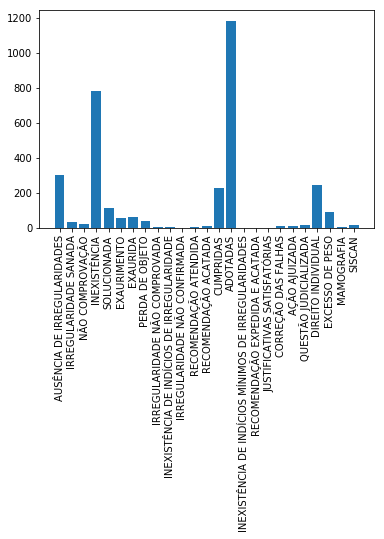

In [18]:
plot_keywords(p_homologados)

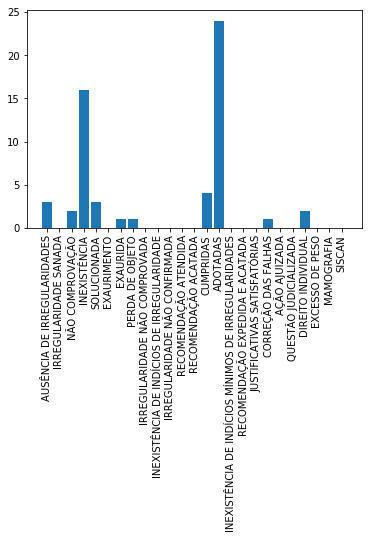

In [19]:
plot_keywords(p_nao_homologados)

# Treinando um modelo com Random Forest

In [20]:
# vamos treinar o modelo
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((3611, 28), (1204, 28))

In [ ]:
'''
IDEIA: criar uma variável que representa a soma dos valores das palavra-chaves.
Em suma, vai indicar o númeto de palavras-chaves presentes no texto.
'''

In [27]:
cols_to_remove = ['id', 'peca_promocao', 'homologado']
features = [col for col in df_work.columns if col not in cols_to_remove]

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])

['AUSÊNCIA DE IRREGULARIDADES',
 'IRREGULARIDADE SANADA',
 'NÃO COMPROVAÇÃO',
 'INEXISTÊNCIA',
 'SOLUCIONADA',
 'EXAURIMENTO',
 'EXAURIDA',
 'PERDA DE OBJETO',
 'IRREGULARIDADE NÃO COMPROVADA',
 'INEXISTÊNCIA DE INDÍCIOS DE IRREGULARIDADE',
 'IRREGULARIDADE NÃO CONFIRMADA',
 'RECOMENDAÇÃO ATENDIDA',
 'RECOMENDAÇÃO ACATADA',
 'CUMPRIDAS',
 'ADOTADAS',
 'INEXISTÊNCIA DE INDÍCIOS MÍNIMOS DE IRREGULARIDADES',
 'RECOMENDAÇÃO EXPEDIDA E ACATADA',
 'JUSTIFICATIVAS SATISFATÓRIAS',
 'CORREÇÃO DAS FALHAS',
 'AÇÃO AJUIZADA',
 'QUESTÃO JUDICIALIZADA',
 'DIREITO INDIVIDUAL',
 'EXCESSO DE PESO',
 'MAMOGRAFIA',
 'SISCAN']

In [23]:
model.score(train[features], train['homologado'])

0.9850456937136527

In [24]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

    
print_score()

Accuracy score: 0.9833887043189369
Precision score:  0.9850249584026622
Recall score:  0.9983136593591906
F1 score:  0.9916247906197656


In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   18],
       [   2, 1184]], dtype=int64)